In [1]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
from pathlib import Path
from PIL import Image

In [12]:
im_shape = (250,250)

seed = 10

BATCH_SIZE = 16

# Dataset size limits (set to None to use full dataset)
TRAIN_LIMIT = None  # Limit training samples (e.g., 10k out of 25k)
TEST_LIMIT = None    # Set to None to use all test samples, or specify a number

# Load dataset from Hugging Face Hub
print("Loading dataset from Hugging Face Hub...")
dataset = load_dataset("ysif9/fruit-recognition")

print(f"Original dataset sizes:")
print(f"  Train: {len(dataset['train'])} samples")
print(f"  Test: {len(dataset['test'])} samples")

# Create temporary directories to organize the dataset for ImageDataGenerator
TEMP_DATA_DIR = 'temp_hf_data'
TRAINING_DIR = os.path.join(TEMP_DATA_DIR, 'train')
TEST_DIR = os.path.join(TEMP_DATA_DIR, 'test')

# Function to save images from HF dataset to local directory structure
def prepare_dataset_for_imagedatagenerator(dataset, split_name, output_dir, limit=None):
    """
    Organize HF dataset into directory structure expected by ImageDataGenerator.
    Structure: output_dir/class_name/image_files

    Args:
        dataset: HuggingFace dataset object
        split_name: Name of the split ('train' or 'test')
        output_dir: Directory to save organized images
        limit: Maximum number of samples to use (None for all samples)
    """
    print(f"Preparing {split_name} split...")

    split_data = dataset[split_name]
    total_samples = len(split_data)

    # Apply limit if specified
    if limit is not None and limit < total_samples:
        print(f"  Using {limit} out of {total_samples} samples")
        num_samples = limit
    else:
        print(f"  Using all {total_samples} samples")
        num_samples = total_samples

    for idx in range(num_samples):
        example = split_data[idx]

        # Get image and label
        img = example['image']
        label = example['label']

        # Create class directory
        class_dir = os.path.join(output_dir, str(label))
        os.makedirs(class_dir, exist_ok=True)

        # Ensure compatibility with JPEG (no alpha channel)
        # Convert RGBA, P (palette), LA, or any other mode to RGB
        if isinstance(img, Image.Image):
            if img.mode != 'RGB':
                img = img.convert('RGB')
        else:
            # If it's a numpy array or other format, convert to PIL then RGB
            img = Image.fromarray(np.array(img)).convert('RGB')

        # Save image as JPEG
        img_path = os.path.join(class_dir, f'{split_name}_{idx}.jpg')
        img.save(img_path, 'JPEG')

    print(f"Completed {split_name} split: {num_samples} images saved")

# Prepare the dataset with limits
prepare_dataset_for_imagedatagenerator(dataset, 'train', TRAINING_DIR, limit=TRAIN_LIMIT)
prepare_dataset_for_imagedatagenerator(dataset, 'test', TEST_DIR, limit=TEST_LIMIT)

print(f"\nDataset prepared successfully!")
print(f"Training directory: {TRAINING_DIR}")
print(f"Test directory: {TEST_DIR}")

Loading dataset from Hugging Face Hub...
Original dataset sizes:
  Train: 25659 samples
  Test: 7070 samples
Preparing train split...
  Using all 25659 samples


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Completed train split: 25659 images saved
Preparing test split...
  Using all 7070 samples
Completed test split: 7070 images saved

Dataset prepared successfully!
Training directory: temp_hf_data/train
Test directory: temp_hf_data/test


In [13]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [14]:
train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=True, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = val_data_generator.flow_from_directory(TRAINING_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")


test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(TEST_DIR, target_size=im_shape, shuffle=False, seed=seed,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 20536 images belonging to 20 classes.
Found 5123 images belonging to 20 classes.
Found 7070 images belonging to 20 classes.
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9']


In [15]:
model = Sequential()
model.add(Conv2D(20, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(im_shape[0],im_shape[1],3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(40, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 248, 248, 20)   │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 124, 124, 20)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 122, 122, 40)   │         7,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 595360)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │    59,536,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │         2,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,545,920 (227.15 MB)

 Trainable params: 59,545,920 (227.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 5

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='models/model.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

#Training
history = model.fit(
        train_generator,
        steps_per_epoch=nb_train_samples // BATCH_SIZE,
        epochs=epochs,
        callbacks = callbacks_list,
        validation_data=validation_generator,
        verbose = 1,
        validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2876 - loss: 3.4429
Epoch 1: val_loss improved from inf to 1.69905, saving model to models/model.h5


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 88s 67ms/step - accuracy: 0.2877 - loss: 3.4419 - val_accuracy: 0.4752 - val_loss: 1.6990
Epoch 2/5
   1/1283 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.6250 - loss: 1.6676

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.69905
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.6250 - loss: 1.6676 - val_accuracy: 0.4709 - val_loss: 1.7141
Epoch 3/5
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7679 - loss: 0.7930
Epoch 3: val_loss did not improve from 1.69905
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 72s 56ms/step - accuracy: 0.7680 - loss: 0.7930 - val_accuracy: 0.5420 - val_loss: 1.7366
Epoch 4/5
   1/1283 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.8125 - loss: 0.6515
Epoch 4: val_loss did not improve from 1.69905
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8125 - loss: 0.6515 - val_accuracy: 0.5410 - val_loss: 1.7346
Epoch 5/5
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9633 - loss: 0.1418
Epoch 5: val_loss did not improve from 1.69905
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 71s 55ms/step - accuracy: 0.9633 - loss: 0.1418 - val_accuracy: 0.5512 - val_loss: 2.5268


In [17]:
# Load the best saved model
from tensorflow.keras.models import load_model

model = load_model('models/model.h5')

In [18]:
# Using the validation dataset
score = model.evaluate(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

321/321 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4476 - loss: 1.7722
Val loss: 1.698785424232483
Val accuracy: 0.475307434797287


In [19]:

score = model.evaluate(test_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



442/442 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4326 - loss: 1.8598
Test loss: 1.7193105220794678
Test accuracy: 0.47623762488365173


442/442 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step


Text(0.5, 1.0, 'Confusion Matrix')

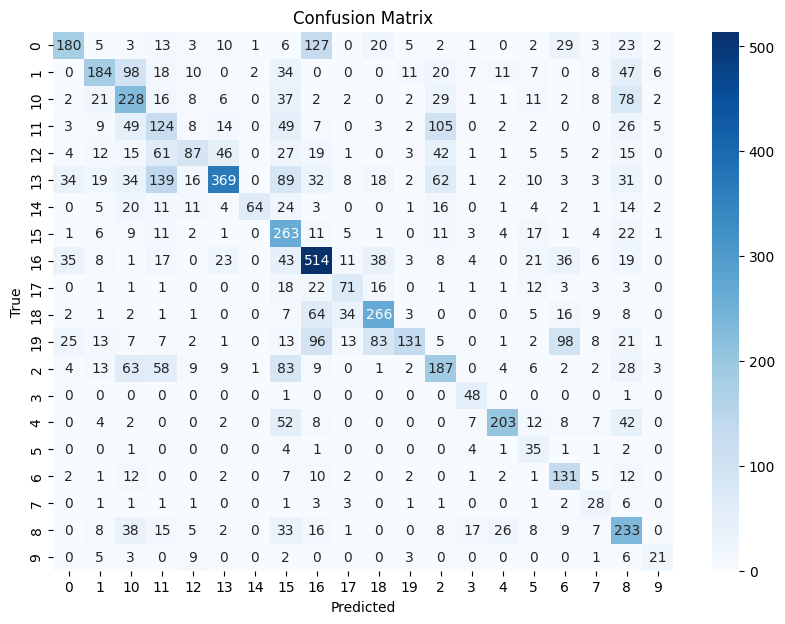

In [20]:
# Some reports
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

#Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [21]:
#Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))


Classification Report
              precision    recall  f1-score   support

           0       0.62      0.41      0.50       435
           1       0.58      0.40      0.47       463
          10       0.39      0.50      0.44       456
          11       0.25      0.30      0.28       408
          12       0.51      0.25      0.34       346
          13       0.75      0.42      0.54       872
          14       0.94      0.35      0.51       183
          15       0.33      0.71      0.45       373
          16       0.54      0.65      0.59       787
          17       0.47      0.46      0.47       154
          18       0.60      0.63      0.62       419
          19       0.77      0.25      0.38       527
           2       0.38      0.39      0.38       484
           3       0.50      0.96      0.66        50
           4       0.78      0.59      0.67       347
           5       0.22      0.70      0.33        50
           6       0.38      0.69      0.49       190
     